# Explore here

Sistema de detección de anomalías en el uso de la CPU
Queremos entrenar un sistema que sea capaz de predecir cuál puede ser el gasto computacional de la CPU de un ordenador en función de sus datos históricos. Para ello, hemos capturado algunos datos durante cada minuto varios días para tratar de entrenar un modelo.

## Paso 1: Carga del conjunto de datos

In [72]:
# Your code here
import pandas as pd

train_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/cpu-train.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/cpu-test.csv")

train_data.head()

,datetime,cpu
0,2017-01-27 18:42:00,1.14
1,2017-01-27 18:43:00,1.10
2,2017-01-27 18:44:00,1.09
3,2017-01-27 18:45:00,1.08
4,2017-01-27 18:46:00,1.08


In [73]:
#Transformar cadena date a objeto datetime

train_data["datetime"] = pd.to_datetime(train_data.datetime)
train_data = train_data.set_index("datetime")
ts_train = train_data["cpu"]
ts_train.head()

datetime
2017-01-27 18:42:00    1.14
2017-01-27 18:43:00    1.10
2017-01-27 18:44:00    1.09
2017-01-27 18:45:00    1.08
2017-01-27 18:46:00    1.08
Name: cpu, dtype: float64

In [74]:
#Transformar cadena date a objeto datetime

test_data["datetime"] = pd.to_datetime(test_data.datetime)
test_data = test_data.set_index("datetime")
ts_test = test_data["cpu"]
ts_test.head()

datetime
2017-01-28 04:42:00    1.71
2017-01-28 04:43:00    1.58
2017-01-28 04:44:00    1.86
2017-01-28 04:45:00    1.66
2017-01-28 04:46:00    1.61
Name: cpu, dtype: float64

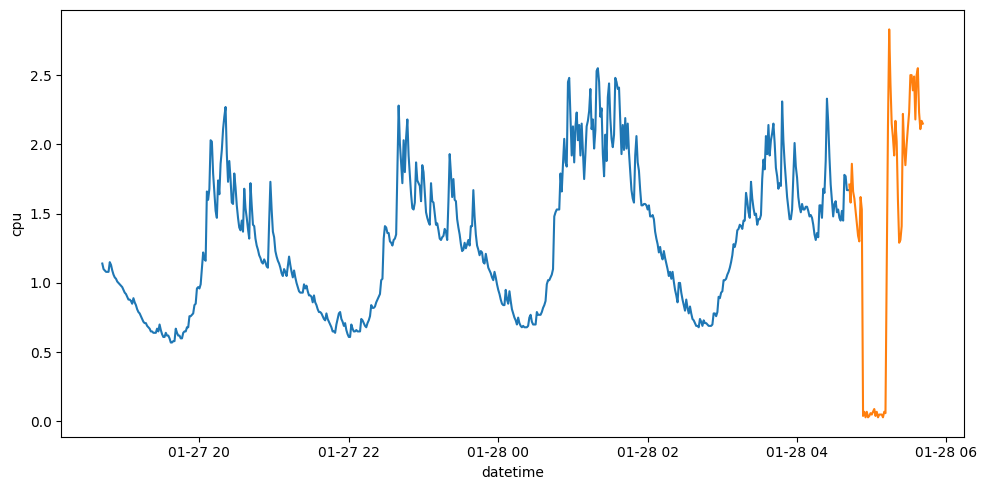

In [75]:
#ploteamos

import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_train)
sns.lineplot(data = ts_test)

plt.tight_layout()

plt.show()

## Paso 2: Construye y analiza la serie temporal

In [76]:
#Descomposición de la serie

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_train, period = 24)
decomposition

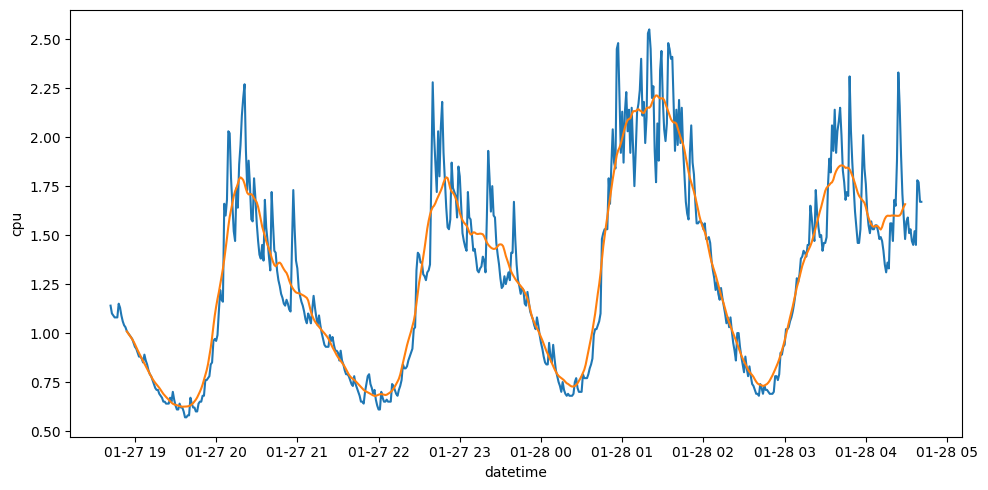

In [77]:
#Análisis de la tendencia

trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_train)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

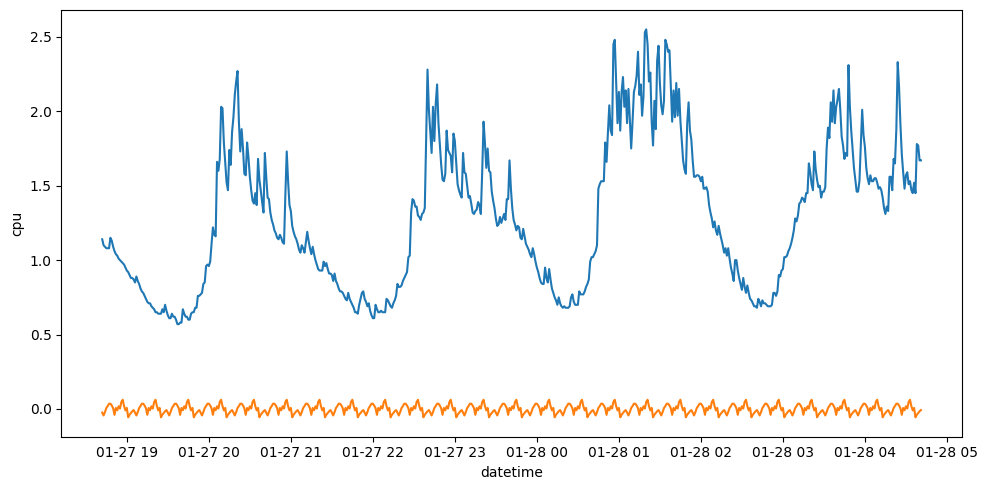

In [78]:
#Análisis de la estacionalidad

seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_train)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [79]:
#Prueba de Dickey-Fuller (Dickey-Fuller test)

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts_train)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                  -3.421625
p-value                          0.010243
#Lags Used                      18.000000
Number of Observations Used    581.000000
Critical Value (1%)             -3.441655
Critical Value (5%)             -2.866527
Critical Value (10%)            -2.569426
dtype: float64

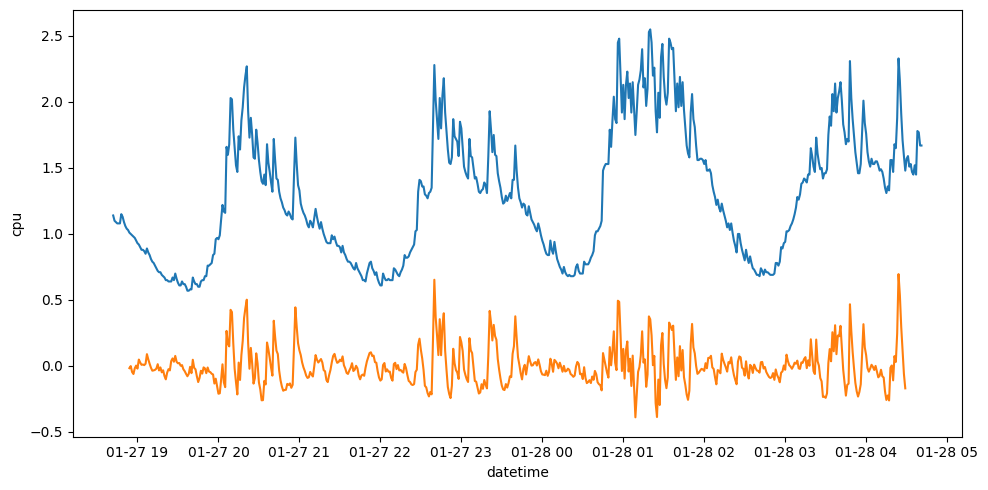

In [80]:
#Análisis de la variabilidad

residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_train)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

riudogenralizado y pude dificultar la visivulada modelo

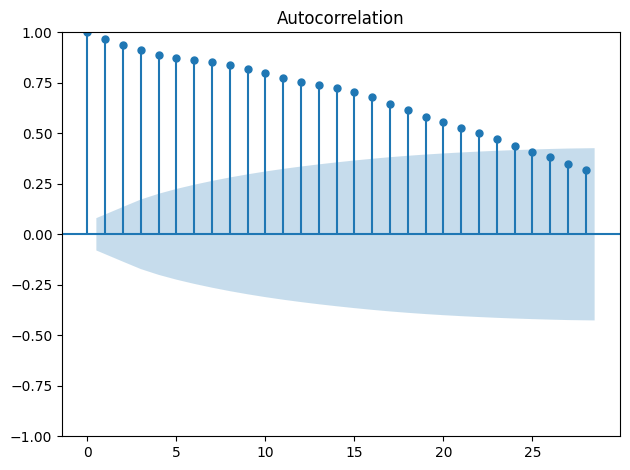

In [81]:
#Análisis de la autocorrelación

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts_train)

plt.tight_layout()

plt.show()

la correlacion se va perdiendo con el tiempo por el tema del ruido. los puntos finales casi no fuardan correlacion con el modelo

## Paso 3: Entrenamiento del modelo

In [82]:
'''#para optimizar al máximo sus resultados, debemos transformar la serie en estacionaria

ts_stationary = ts_train.diff().dropna()

test_stationarity(ts_stationary)'''

'#para optimizar al máximo sus resultados, debemos transformar la serie en estacionaria\n\nts_stationary = ts_train.diff().dropna()\n\ntest_stationarity(ts_stationary)'

In [83]:
#aplicar el método ARIMA automático

from pmdarima import auto_arima

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 24)

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=18.03 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-812.814, Time=0.27 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-809.989, Time=3.00 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-810.139, Time=2.39 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-814.783, Time=0.12 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=-811.059, Time=2.26 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=-811.046, Time=3.81 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=-809.013, Time=1.76 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-811.743, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=-811.910, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=1.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 33.415 seconds


In [84]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  599
Model:                        SARIMAX   Log Likelihood                 408.391
Date:                Fri, 04 Aug 2023   AIC                           -814.783
Time:                        21:24:24   BIC                           -810.387
Sample:                    01-27-2017   HQIC                          -813.071
                         - 01-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0150      0.000     30.648      0.000       0.014       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):               611.96
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                             1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
#Predicción del modelo

forecast = model.predict(80)
forecast

2017-01-28 04:42:00    0.0
2017-01-28 04:43:00    0.0
2017-01-28 04:44:00    0.0
2017-01-28 04:45:00    0.0
2017-01-28 04:46:00    0.0
                      ... 
2017-01-28 05:57:00    0.0
2017-01-28 05:58:00    0.0
2017-01-28 05:59:00    0.0
2017-01-28 06:00:00    0.0
2017-01-28 06:01:00    0.0
Freq: T, Length: 80, dtype: float64

hay mucho ruido y pocas nueces XD por eso se queda todo a 0. Es un fracaso de moldeo

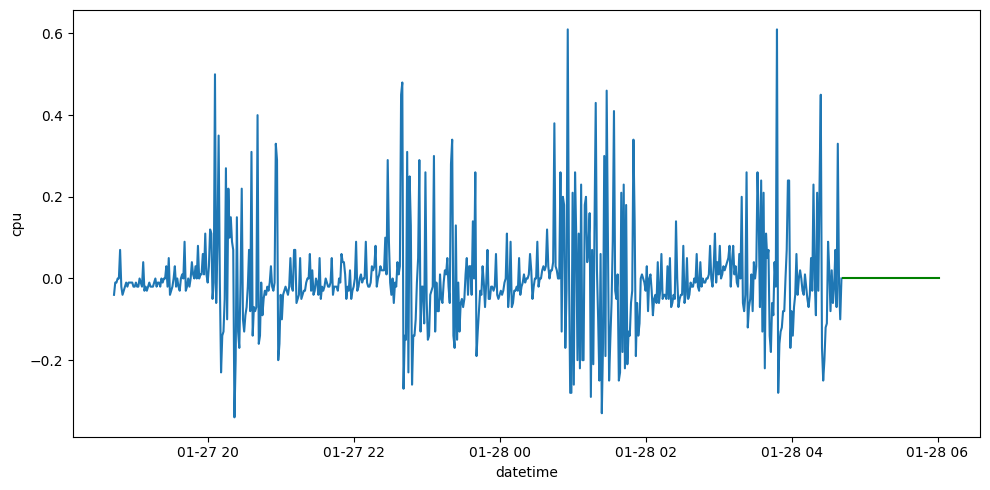

In [86]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()